<a href="https://colab.research.google.com/github/jo-ann1902/booleanbusinessbundestag/blob/main/DIS25_Bundestag_Plenarprotokolle_ethnic_bias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Loading into Pandas dataframes
The data is located on a google drive folder.

In [2]:
import pandas as pd

In [3]:
"""
Data Loading XML into Pandas 
"""
import pandas as pd
import xml.etree.ElementTree as et
def parse_XML(xml_file): 
    """Parse the input XML file and store the result in a pandas 
    DataFrame with the given columns. 
    
    The first element of df_cols is supposed to be the identifier 
    variable, which is an attribute of each node element in the 
    XML data; other features will be parsed from the text content 
    of each sub-element. 
    """
    xtree = et.parse(xml_file)
    xroot = xtree.getroot()
    election_period = xroot.find("WAHLPERIODE").text
    doc_type        = xroot.find("DOKUMENTART").text
    n_doc           = xroot.find("NR").text
    date            = xroot.find("DATUM").text
    title           = xroot.find("TITEL").text
    text            = xroot.find("TEXT").text
    rows = [[election_period,doc_type,n_doc,date,title,text]]
    out_df = pd.DataFrame(rows, columns=["election period","document type","number document","date","title","text"])   
    return out_df

In [4]:
'''
    For the given path, get the List of all files in the directory tree 
'''
import os
def getListOfFiles(dirName):
    # create a list of file and sub directories 
    # names in the given directory 
    listOfFile = os.listdir(dirName)
    allFiles = list()
    # Iterate over all the entries
    for entry in listOfFile:
        # Create full path
        fullPath = os.path.join(dirName, entry)
        # If entry is a directory then get the list of files in this directory 
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
                
    return allFiles

In [5]:
all_files_paths = getListOfFiles("/content/drive/My Drive/xml/xmls")
print("we have {} xml file in total".format(len(all_files_paths)))

we have 1563 xml file in total


In [6]:
"""
Convert all xml files into pandas dataframe
"""
from tqdm import tqdm
def convert_files(list_xml):
  dfs = []
  for file in tqdm(list_xml):
    try:
      df = parse_XML(file)
      dfs.append(df)
    except:
      continue
  df_total = pd.concat(dfs)
  return df_total

In [7]:
df_final = convert_files(all_files_paths)

100%|██████████| 1563/1563 [00:20<00:00, 75.68it/s]


In [8]:
df_final.shape

(1554, 6)

In [9]:
df_final.head()

,election period,document type,number document,date,title,text
0,13,PLENARPROTOKOLL,13/110,13.06.1996,Plenarprotokoll vom 13.06.1996,Plenarprotokoll 13/110\n(Zu diesem Protokoll f...
0,13,PLENARPROTOKOLL,13/238,28.05.1998,Plenarprotokoll vom 28.05.1998,Plenarprotokoll 13/238\nDeutscher Bundestag\nS...
0,13,PLENARPROTOKOLL,13/241,18.06.1998,Plenarprotokoll vom 18.06.1998,Plenarprotokoll 13/241\nDeutscher Bundestag\nS...
0,13,PLENARPROTOKOLL,13/244,24.06.1998,Plenarprotokoll vom 24.06.1998,Plenarprotokoll 13/244\nDeutscher Bundestag\nS...
0,13,PLENARPROTOKOLL,13/47,29.06.1995,Plenarprotokoll vom 29.06.1995,Plenarprotokoll 13/47\nDeutscher Bundestag\nSt...


## Data Cleaning

In [10]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re

stemmer = SnowballStemmer("german")
stop_words = set(stopwords.words("german"))


def clean_text(text, for_embedding=False):
    """
        - remove any html tags (< /br> often found)
        - Keep only ASCII + European Chars and whitespace, no digits
        - remove single letter chars
        - convert all whitespaces (tabs etc.) to single wspace
        if not for embedding (but e.g. tdf-idf):
        - all lowercase
        - remove stopwords, punctuation and stemm
    """
    RE_WSPACE = re.compile(r"\s+", re.IGNORECASE)
    RE_TAGS = re.compile(r"<[^>]+>")
    RE_ASCII = re.compile(r"[^A-Za-zÀ-ž ]", re.IGNORECASE)
    RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž]\b", re.IGNORECASE)
    if for_embedding:
        # Keep punctuation
        RE_ASCII = re.compile(r"[^A-Za-zÀ-ž,.!? ]", re.IGNORECASE)
        RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž,.!?]\b", re.IGNORECASE)

    text = re.sub(RE_TAGS, " ", text)
    text = re.sub(RE_ASCII, " ", text)
    text = re.sub(RE_SINGLECHAR, " ", text)
    text = re.sub(RE_WSPACE, " ", text)

    word_tokens = word_tokenize(text)
    words_tokens_lower = [word.lower() for word in word_tokens]

    if for_embedding:
        # no stemming, lowering and punctuation / stop words removal
        words_filtered = word_tokens
    else:
        words_filtered = [
            stemmer.stem(word) for word in words_tokens_lower if word not in stop_words
        ]

    text_clean = " ".join(words_filtered)
    return text_clean

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
df_final["text_clean"] = df_final["text"].map(lambda x: clean_text(x, for_embedding=False) if isinstance(x, str) else x)

In [12]:
df_final.to_csv('/content/drive/My Drive/xml/clean.csv',index=False)

In [13]:
df_clean = df_final.drop('text',axis=1)

In [14]:
df_final.head()

,election period,document type,number document,date,title,text,text_clean
0,13,PLENARPROTOKOLL,13/110,13.06.1996,Plenarprotokoll vom 13.06.1996,Plenarprotokoll 13/110\n(Zu diesem Protokoll f...,plenarprotokoll protokoll folgt nachtrag deuts...
0,13,PLENARPROTOKOLL,13/238,28.05.1998,Plenarprotokoll vom 28.05.1998,Plenarprotokoll 13/238\nDeutscher Bundestag\nS...,plenarprotokoll deutsch bundestag stenograph b...
0,13,PLENARPROTOKOLL,13/241,18.06.1998,Plenarprotokoll vom 18.06.1998,Plenarprotokoll 13/241\nDeutscher Bundestag\nS...,plenarprotokoll deutsch bundestag stenograph b...
0,13,PLENARPROTOKOLL,13/244,24.06.1998,Plenarprotokoll vom 24.06.1998,Plenarprotokoll 13/244\nDeutscher Bundestag\nS...,plenarprotokoll deutsch bundestag stenograph b...
0,13,PLENARPROTOKOLL,13/47,29.06.1995,Plenarprotokoll vom 29.06.1995,Plenarprotokoll 13/47\nDeutscher Bundestag\nSt...,plenarprotokoll deutsch bundestag stenograph b...


# Analysis

In [15]:
import pandas as pd

In [16]:
df_final = pd.read_csv('/content/drive/My Drive/xml/clean.csv').drop('text',axis=1)

### Model Training (Word2Vec model)

In this section we will train our word2vec model

In [17]:
import multiprocessing
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser

In [18]:
"""multiprocessing is a package that supports spawning processes using an API similar to the threading module."""


'multiprocessing is a package that supports spawning processes using an API similar to the threading module.'

In [19]:
sent = [row.split() for row in df_final['text_clean']]

In [20]:
phrases = Phrases(sent, min_count=30, progress_per=10000)

In [21]:
bigram = Phraser(phrases)

In [22]:
sentences = bigram[sent]

In [23]:
cores = multiprocessing.cpu_count()

In [24]:
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=100,
                     workers=cores-1)

In [25]:
from time import time
t = time()
w2v_model.build_vocab(sent, progress_per=10000)
print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

Time to build vocab: 0.5 mins


In [26]:
t = time()
w2v_model.train(sent, total_examples=w2v_model.corpus_count, epochs=5, report_delay=1)
print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Time to train the model: 3.25 mins


In [27]:
w2v_model.init_sims(replace=True)

In [28]:
w2v_model.save("/content/drive/My Drive/xml/models/word2vec2.model")

### Word extraction

In [29]:
!pip install googletrans==3.1.0a0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [30]:
import gensim
mvk = gensim.models.Word2Vec.load("/content/drive/My Drive/xml/models/word2vec2.model")

In [31]:
from googletrans import Translator
translator = Translator()

In [32]:
all = ['deutsch', 'deutscher', 'deutsche', #'deutschland',
       'türkisch', 'türke', 'türken', #'türkei',
       'polnisch', 'polin', 'pole', #'polen',
       'russen', 'russisch', 'russin', #'russland',
       'griechisch', 'grieche', 'griechen', #'griechenland',
       'rumänisch', 'rumäne', 'rumänen', #'rumänien',
       'arabisch',
       'italienisch', 'italiäner', #'italien',
       'syrisch', 'syrer', 'syrien',
       'niederländisch', 'niederländer', #'niederlande', 'holland',
       'marokkanisch', 'marokkaner', #'marokko',
       'somali', 'somalien',
       'afghanisch', 'afghane', 'afghanen', #'afghanistan',
       'irakisch', 'irake', 'iraken', #'irak',
       'ausländer', 'einwanderer', 'flüchtling', 'flüchtlinge', 'migrant']

### Compute frequency

In [33]:
from googletrans import Translator

In [34]:
list_word_german1 = []
for l in all:
  list_word_german1.append(translator.translate(l, dest='german').text)
all = all+list_word_german1

In [35]:
def compute_frequency(word_list):
  dict_r = {}
  for wordd in word_list:
    sum_freq = 0
    for word in [wordd,wordd+'s']:
      try:
        freq_words = [x[0] for x in mvk.wv.most_similar(positive=word, topn=100)]
        for f in freq_words:
          freq = mvk.wv.vocab[f].count
          sum_freq+=freq
        dict_r[wordd] = sum_freq
      except:
        continue
  return dict_r

In [36]:
frequencies = compute_frequency(all)
frequencies

{'deutsch': 516296,
 'polnisch': 95227,
 'russisch': 96400,
 'griechisch': 68429,
 'syrisch': 59671,
 'somali': 9426,
 'migrant': 222866}

In [37]:
groupss = {'deutsch':'ingroup','griechisch':'outgroup','migrant':'outgroup','polnisch':'outgroup','somali':'outgroup','syrisch':'outgroup','russisch':'outgroup'}

### Compute High-threat and low status



In [38]:
import multiprocessing
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser

In [39]:
import re
high_treat_words =  open("/content/drive/My Drive/xml/ressources/high threat.txt","r").read()
low_status       =  open("/content/drive/My Drive/xml/ressources/low statuts.txt","r").read()
crime            =  open("/content/drive/My Drive/xml/ressources/crime.txt","r").read()

high_treat_words =  [i.lstrip() for i in re.sub('\s+',' ',high_treat_words).split(',') ]
low_status       =  [i.lstrip() for i in re.sub('\s+',' ',low_status).split(',')]
crime       = crime.split('\n')
high_treat_words = high_treat_words+crime
low_status_trans = []
high_treat_trans  = []
for l in low_status:
  low_status_trans.append(translator.translate(l, dest='german').text)
for l in high_treat_words:
  high_treat_trans.append(translator.translate(l, dest='german').text)
for l in crime:
  high_treat_trans.append(translator.translate(l, dest='german').text)
high_threat_all = high_treat_trans + high_treat_words
low_status_all  = low_status_trans + low_status

In [40]:
import itertools
tars = list(frequencies.keys())
def get_scores(inputt):
  scores = {}
  for tar in tars:
    sum = 0
    for pair in inputt:
        try:
          resultaat_tel = mvk.wv.similarity(pair,tar)
        except KeyError:
          resultaat_tel = 0
        sum+=resultaat_tel
    scores[tar] = sum/len(inputt)
  return scores

In [41]:

df_results = pd.DataFrame()
df_results['names'] = list(frequencies.keys())
df_results['frequencies'] = list(frequencies.values())
df_results['groups'] = ['outgroup','outgroup','outgroup','outgroup','outgroup','outgroup','ingroup']
scores_lowstatus  = get_scores(low_status_all)
scores_highthreat = get_scores(high_threat_all)
df_results['scores_lowstatus']  = [x*10 for x in list(scores_lowstatus.values())]
df_results['scores_highthreat'] = [x*10 for x in list(scores_highthreat.values())]
df_results["names:group"] = df_results["names"] + '/'+ df_results["groups"]
df_results.drop(['names','groups'],axis=1,inplace=True)
df_results

,frequencies,scores_lowstatus,scores_highthreat,names:group
0,516296,0.012374,0.006080,deutsch/outgroup
1,95227,0.041002,0.044219,polnisch/outgroup
2,96400,0.064851,0.066703,russisch/outgroup
3,68429,0.083226,0.044200,griechisch/outgroup
4,59671,0.126072,0.089379,syrisch/outgroup
5,9426,0.207590,0.093715,somali/outgroup
6,222866,0.182398,0.057862,migrant/ingroup


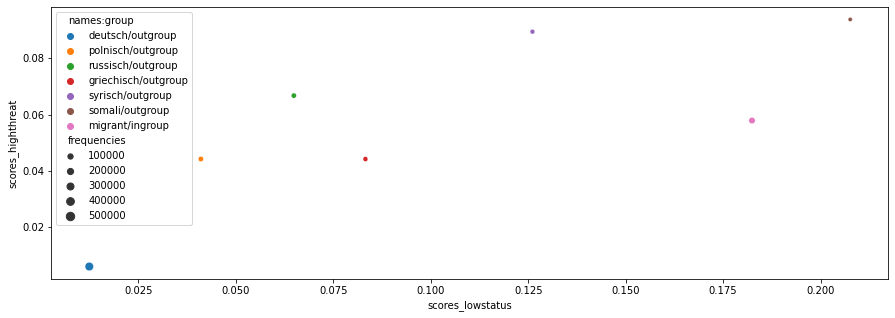

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
sns.scatterplot(data=df_results,x='scores_lowstatus',y='scores_highthreat',hue="names:group",size="frequencies")

In [1]:
del mvk

NameError: ignored

### Question 1

Hypothesis 1 (H1): Does politicans implicitly associate ethnic outgroups more
strongly with low-status traits than ethnic ingroups. 

* Low statuts traits are clearly associated with ingroups, which is represented by the low status score of deutsch (about 0.001) and griechish (about 0.06). In the other hand, we can observe high low status regrading outgroups such as migrant with a score of (>0.17) and pool(more than 0.2).

### Question 2

Hypothesis 2 (H2): Does politicans implicitly associate ethnic outgroups more
strongly with high-threat traits than to ethnic ingroups. 

* Regarding the plot above generated from word2vec trained model, we can observe the following:
  * The most frequent InGroup (deutsh) is clearly related to a very low high_threat score (less than 0.01 as a highThreat score). Where outgroups have a greater score.

Thus, the answer of our question is that politician relate HighThreat with outgroups than ingroups.




### Over Time analysis

In [2]:
df_final.head(-1)

NameError: ignored

In [45]:
period_1 = '01-01-1994'
period_2 = '01-01-1998'
period_3 = '01-01-2002'

In [46]:
df_final['date'] = pd.to_datetime(df_final['date'])

In [47]:
df_final[(df_final['date'] > period_1) & (df_final['date'] <= period_2)].shape

(157, 6)

In [48]:
def train_time(period1,period2=None,fin=False):
    p = period1.split('-')[2]
    if fin==False:
      df_p = df_final[(df_final['date'] > period1) & (df_final['date'] <= period2)]
    else:
      df_p = df_final[df_final['date'] > period1]
    sent = [row.split() for row in df_p['text_clean']]
    phrases = Phrases(sent, min_count=30, progress_per=10000)
    bigram = Phraser(phrases)
    sentences = bigram[sent]
    cores = multiprocessing.cpu_count()
    w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=100,
                     workers=cores-1)
    w2v_model.build_vocab(sent, progress_per=10000)
    w2v_model.train(sent, total_examples=w2v_model.corpus_count, epochs=5, report_delay=1)
    w2v_model.save("/content/drive/My Drive/xml/models/word2vec_{}.model".format(p))

In [49]:
train_time(period_1,period_2)

In [50]:
train_time(period_2,period_3)

In [ ]:
train_time(period_3,fin=True)

In [ ]:
def compute_frequenccy(word_list,mvk_in):
  dict_r = {}
  for wordd in word_list:
    sum_freq = 0
    for word in [wordd,wordd+'s']:
      try:
        freq_words = [x[0] for x in mvk_in.wv.most_similar(positive=word, topn=100)]
        for f in freq_words:
          freq = mvk_in.wv.vocab[f].count
          sum_freq+=freq
        dict_r[wordd] = sum_freq
      except:
        continue
  return dict_r
def get_scores_time(inputt,mvk_in):
  scores = {}
  for tar in tars:
    sum = 0
    for pair in inputt:
        try:
          resultaat_tel = mvk_in.wv.similarity(pair,tar)
        except KeyError:
          resultaat_tel = 0
        sum+=resultaat_tel
    scores[tar] = sum/len(inputt)
  return scores
def analysis_time(modelll):
  mvkk = gensim.models.Word2Vec.load(modelll)
  frequencies = compute_frequenccy(all,mvkk)
  tars = list(frequencies.keys())
  df_results = pd.DataFrame()
  df_results['names'] = list(frequencies.keys())
  df_results['frequencies'] = list(frequencies.values())
  df_results['groups'] = [groupss[name] for name in df_results.names.values]
  scores_lowstatus  = get_scores_time(low_status_all,mvkk)
  scores_highthreat = get_scores_time(high_threat_all,mvkk)
  scores_lowstatus  = { your_key: scores_lowstatus[your_key] for your_key in tars }
  scores_highthreat  = { your_key: scores_highthreat[your_key] for your_key in tars }
  df_results['scores_lowstatus']  = [x*10 for x in list(scores_lowstatus.values())]
  df_results['scores_highthreat'] = [x*10 for x in list(scores_highthreat.values())]
  df_results["names:group"] = df_results["names"] + '/'+ df_results["groups"]
  df_results.drop(['names','groups'],axis=1,inplace=True)
  return df_results

In [ ]:
import gensim
period1_results = analysis_time("/content/drive/My Drive/xml/models/word2vec_1994.model")
period2_results = analysis_time("/content/drive/My Drive/xml/models/word2vec_1998.model")
period3_results = analysis_time("/content/drive/My Drive/xml/models/word2vec_2002.model")

In [ ]:
period1_results

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(15,5))
sns.scatterplot(data=period1_results,x='scores_lowstatus',y='scores_highthreat',hue="names:group",size="frequencies")

In [ ]:
period2_results

In [ ]:
plt.figure(figsize=(15,5))
sns.scatterplot(data=period2_results,x='scores_lowstatus',y='scores_highthreat',hue="names:group",size="frequencies")

In [ ]:
period3_results

In [ ]:
plt.figure(figsize=(15,5))
sns.scatterplot(data=period3_results,x='scores_lowstatus',y='scores_highthreat',hue="names:group",size="frequencies")

### Question 3
Over time, the strength of implicit stereotypical associations in
plenary documents content will increase for ethnic outgroups, while this will not be the case for ethnic ingroups. 

* Over Time, we can observe from the 3 plots of 3 diffrents periods, thats the points represnting outgroups are moving to to right and to the top, period by period which mean that thier low status/ high treat scores are increasing over time for outgroups.

In the other hand, In groups are reciving almost the same low scores over time.





In [ ]:
r

#### Question 4

Research Question 1 (RQ1): To what extent do real-world integration outcomes (i.e., representation of ethnic groups among criminality rates and the distribution of social benefits) affect the evolution of in implicit stereotypical associations the news media content?

* As our analysis showen ,We expect that the stereotypicality of news media
content about ethnic out-groups will increase over time for the following reasons. Because Political content is likely to mirror increasingly unfavorable public perceptions about minority groups, As the elections are always search for the majority(ingroups) votes. 